In [1]:
import cv2
import numpy as np
import os
import math
from matplotlib import pyplot as plt
from IPython.display import clear_output


In [2]:
def cut_faces(image, faces_coord):
    faces = []
      
    for (x, y, w, h) in faces_coord:
        w_rm = int(0.2 * w / 2)
        faces.append(image[y: y + h, x + w_rm: x + w - w_rm])
         
    return faces

def detect_face(frame):
    detector = cv2.CascadeClassifier("xml/frontal_face.xml")

    scale_factor = 1.2
    min_neighbors =5
    min_size = (30,30)
    flags = cv2.CASCADE_SCALE_IMAGE

    faces = detector.detectMultiScale(frame,scaleFactor=scale_factor,
                                     minNeighbors=min_neighbors,
                                     minSize=min_size,
                                     flags=flags)
    
    return faces

def gray_scale(images):
    gray_images = []
    for image in images:
        is_color = len(image.shape) == 3 
        if is_color:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        gray_images.append(image)
    return gray_images

def resize(images,size=(90,90)):
    image_resize = []
    
    for image in images:
        if image.shape < size:
            img_size = cv2.resize(image,size,
                                     interpolation=cv2.INTER_AREA)
        else:
            img_size = cv2.resize(image,size,
                                     interpolation=cv2.INTER_CUBIC)
        image_resize.append(img_size)
        
    return image_resize

def normalize_faces(frame, faces_coord):
    faces = cut_faces(frame, faces_coord)
    #faces = normalize_intensity(faces)
    faces = gray_scale(faces)
    faces = resize(faces)
    return faces

def draw_rectangle(image, coords):
    for (x, y, w, h) in coords:
        w_rm = int(0.2 * w / 2) 
        cv2.rectangle(image, (x + w_rm, y), (x + w - w_rm, y + h), 
                              (0,0,255),2)

In [4]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from IPython.display import clear_output

%matplotlib inline

# Open a new thread to manage the external cv2 interaction
cv2.startWindowThread()

def plt_show(image,title=""):
    if len(image.shape)==3:
        image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    plt.axis('off')
    plt.title(title)
    plt.imshow(image,cmap="Greys_r")
    plt.show()

class FaceDetector():
    def __init__(self,xml_path):
        self.classifier = cv2.CascadeClassifier(xml_path)

    def detect(self,image):
        scale_factor = 1.2
        min_neighbors=5
        min_size=(30,30)
        flags = cv2.CASCADE_SCALE_IMAGE

        faces_coord = self.classifier.detectMultiScale(image,minNeighbors=min_neighbors,minSize = min_size,flags=flags)

        return faces_coord


class VideoCamera():
    def __init__(self,index=0):
        self.video = cv2.VideoCapture(index)
        self.index=index
        print (self.video.isOpened())

    def __del__(self):
        self.video.release()

    def get_frame(self,grayscale=False):
        ret,frame = self.video.read()

        if grayscale:
            frame = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
        return frame

In [5]:
def collect_dataset():
    images = []
    labels = []
    labels_dic = {}
    #people = [person for person in os.listdir("Male_female/")]
    people = [person for person in os.listdir("trainingData/")]
    #people = [person for person in os.listdir("people/")]
    for i, person in enumerate(people):
        labels_dic[i] = person
        for image in os.listdir("trainingData/" + person):
            if image.endswith('.jpg'):
                images.append(cv2.imread("trainingData/" + person + '/' + image, 0))
                labels.append(i)
                #print(images)
    return (images, np.array(labels), labels_dic)

In [6]:
images, labels, labels_dic = collect_dataset()

In [7]:
print (len(images))
print (type(images))

400
<class 'list'>


In [8]:
X_train=np.asarray(images)

In [9]:
X_train.shape

(400, 90, 90)

In [10]:
train=X_train.reshape(len(X_train),-1)

In [12]:
train.shape

(400, 8100)

In [13]:
from sklearn.decomposition import PCA

Text(0,0.5,'cumulative explained variance')

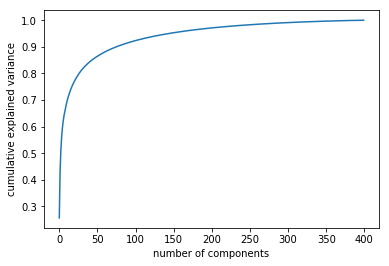

In [14]:
pca1 = PCA()
pca1.fit(train)
plt.plot(np.cumsum(pca1.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [15]:
pca1 = PCA(n_components=400)
new_train=pca1.fit_transform(train)

In [16]:
new_train.shape

(400, 400)

In [17]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import KFold,cross_val_score

models = [KNeighborsClassifier(),LogisticRegression(),SVC(kernel='linear',C=.001)]

kf = KFold(n_splits=10,shuffle=True)


for model in models:
    result = cross_val_score(model,new_train,labels,cv=5,scoring='accuracy')
    
    print (np.mean(result))
    
    

0.905
0.925
0.9200000000000002


In [18]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.model_selection import GridSearchCV,KFold

In [19]:
param_grid = {'C':[.0001,.001,.01,1,10],
              'kernel':['linear','rbf'],
              'gamma':[.0001,.001,.01,.1,10]
             }

In [20]:
kf=KFold(n_splits=10,shuffle=True)

In [21]:
gs_svc = GridSearchCV(SVC(),param_grid=param_grid,cv=kf,scoring='accuracy')

In [22]:
gs_svc.fit(new_train,labels)

GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=True),
       error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.0001, 0.001, 0.01, 1, 10], 'kernel': ['linear', 'rbf'], 'gamma': [0.0001, 0.001, 0.01, 0.1, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [23]:
gs_svc.best_score_

0.9225

In [24]:
gs_svc.best_params_

{'C': 0.0001, 'gamma': 0.0001, 'kernel': 'linear'}

In [25]:
clf_svc = gs_svc.best_estimator_

In [26]:
clf_svc

SVC(C=0.0001, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [27]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(new_train,labels,test_size=.20,random_state=0,
                                              shuffle=True)

In [28]:
clf_svc.fit(X_train,y_train)

SVC(C=0.0001, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [29]:


clf_svc.score(X_train,y_train)

1.0

In [30]:
clf_svc.score(X_test,y_test)

0.9125

### Adaboost

In [31]:
param = {'algorithm':['SAMME.R','SAMME'],
        'base_estimator':[RandomForestClassifier(),None],}

In [32]:
gs_ada = GridSearchCV(AdaBoostClassifier(random_state=1),param_grid=param,cv=kf,scoring='accuracy')

In [33]:
gs_ada.fit(new_train,labels)

GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=True),
       error_score='raise',
       estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'algorithm': ['SAMME.R', 'SAMME'], 'base_estimator': [RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False), None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [40]:
gs_ada.best_score_

0.8825

In [41]:
gs_ada.best_params_

{'algorithm': 'SAMME.R', 'base_estimator': None}

In [42]:
clf_ada = gs_ada.best_estimator_

In [43]:
clf_ada.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=1)

In [44]:
clf_ada.score(X_test,y_test)

0.8375

In [45]:
clf_ada.score(X_train,y_train)

1.0

### save & load model

In [46]:
import pickle

filename = 'svc_model.pkl'
f=open(filename, 'wb')
pickle.dump(clf_svc,f)
 

f.close()


In [47]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.9125


### Live face classification

In [48]:
svc1=gs_svc.best_estimator_
svc1.probability=True
svc1.fit(new_train,labels)

SVC(C=0.0001, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [49]:
detector = FaceDetector("xml/frontal_face.xml")
webcam = VideoCamera(1)

False


In [50]:
cv2.startWindowThread()
font=cv2.FONT_HERSHEY_PLAIN
cv2.namedWindow("opencv_face", cv2.WINDOW_AUTOSIZE)



while True:
    frame = webcam.get_frame()
    
    
    faces_coord = detector.detect(frame) # detect more than one face
    if len(faces_coord):
        faces = normalize_faces(frame, faces_coord) 
        for i, face in enumerate(faces): # for each detected face
            
            
            #cv2.imwrite('trainingData/female/picture_BGR5.jpg',face)
            test = pca1.transform(face.reshape(1,-1))    
            #print test
            #transform = test.reshape(1,-1)
            #print transform
            prob=svc1.predict_proba(test)
            confidence = svc1.decision_function(test)
            print (confidence)
            print (prob)
           
            
            
            pred = svc1.predict(test)
            print (pred,pred[0])
           
            name=labels_dic[pred[0]].capitalize()
            print (name)
            
            #pred = labels_dic[pred[0]].capitalize()
            #threshold = .50
            if confidence > 1:
             
                
                cv2.putText(frame, name,
                            (faces_coord[i][0]
                             , faces_coord[i][1] - 10),
                            cv2.FONT_HERSHEY_PLAIN, 3, (66, 53, 243), 2)
                
            else:
                
                
                cv2.putText(frame, name,
                            (faces_coord[i][0], faces_coord[i][1]),
                            cv2.FONT_HERSHEY_PLAIN, 3, (66, 53, 243), 2)
           
                
                
            #cv2.putText(frame,name,(x,y-10),font,2,(0,0,255),2,cv2.LINE_AA)
            
               
           #cv2.putText(frame,'Unknown',(x,y-10),font,2,(0,0,255),2,cv2.LINE_AA)
        clear_output(wait = True)
        draw_rectangle(frame, faces_coord) # rectangle around face
        
    cv2.putText(frame, "ESC to exit", (5, frame.shape[0] - 5),
                cv2.FONT_HERSHEY_PLAIN, 1.3, (66, 53, 243), 2,
                cv2.LINE_AA)
    
    cv2.imshow("opencv_face", frame) # live feed in external
    if cv2.waitKey(5) & 0xFF == 27:
        
        cv2.destroyAllWindows()
        break

AttributeError: 'NoneType' object has no attribute 'shape'

In [ ]:
del webcam